##### Introduction to DSPy
Dspy allows us to structurally encode the behaviour of our foundation models, it defines a structural way to program instructions into foundation models, and optimizes our instructions for a particular model based on a defined metric

In [19]:
import dspy
from dotenv import load_dotenv
from dspy.datasets.gsm8k import GSM8K, gsm8k_metric


In [21]:
turbo = dspy.OpenAI(model="gpt-3.5-turbo-instruct", max_tokens=250)
dspy.settings.configure(lm=turbo)

In [22]:
# load dataset
gsm8k = GSM8K()
gsm8k_trainset, gsm8k_devset = gsm8k.train[:10], gsm8k.test[:10]

100%|██████████| 1319/1319 [00:00<00:00, 71934.77it/s]


##### Define the module
With our environments setup, we will now define a custom program that uses ChainOfThought module to perform step by step reasoning to generate answers


In [23]:
class CoT(dspy.Module):
    def __init__(self):
        super().__init__()
        self.prog = dspy.ChainOfThought("question -> answer")
    
    def forward(self, question):
        return self.prog(question=question)

##### Compile and Evaluate model
Now that we have defined our module and our dataset, we can then compile the moodel, it is during the compilation step where the optimizations take place. We also define a metric for optimizing the model. We will be performing optimiztions using the `BootstrapFewShotWithRandomSearch` teleprompter. 

In [26]:
from dspy.teleprompt import BootstrapFewShot
config = dict(max_bootstrapped_demos=4, max_labeled_demos=4)

teleprompter = BootstrapFewShot(metric=gsm8k_metric, **config)
optimized_cot = teleprompter.compile(CoT(), trainset=gsm8k_trainset, valset=gsm8k_devset)


 50%|█████     | 5/10 [00:00<00:00, 4740.40it/s]

Bootstrapped 4 full traces after 6 examples in round 0.


##### Evaluate 
Now that we have a compiled(optimized) DSPy program, let's move to evaluating its performance of the dev dataset


In [27]:
from dspy.evaluate import Evaluate

evaluate = Evaluate(devset=gsm8k_devset, metric=gsm8k_metric, num_threads=4, 
                    display_progress=True, display_table=0)

evaluate(optimized_cot)

Average Metric: 8 / 10  (80.0): 100%|██████████| 10/10 [00:00<00:00, 3867.14it/s]

Average Metric: 8 / 10  (80.0%)


80.0

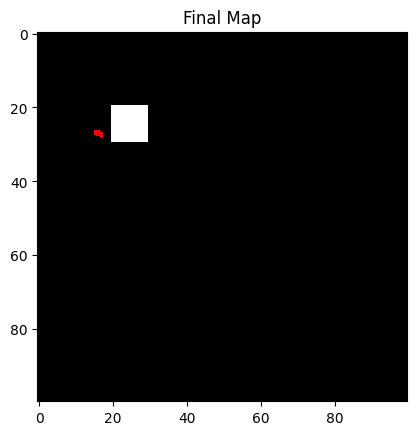

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
num_particles = 1000
map_size = 100  # Map size (square)

# Generate random map
true_map = np.zeros((map_size, map_size))
true_map[20:30, 20:30] = 1  # Example obstacle

# Initialize particles
particles = np.random.rand(num_particles, 3) * map_size
particles[:, 2] = np.random.rand(num_particles) * 2 * np.pi  # Random initial heading

# Motion model parameters
motion_noise = 0.1
turn_noise = 0.1

# Sensor model parameters
sensor_range = 5
measurement_noise = 0.1

# Simulate motion and measurement
def move_particles(particles, motion):
    particles[:, 0] += np.cos(particles[:, 2]) * motion[0]
    particles[:, 1] += np.sin(particles[:, 2]) * motion[0]
    particles[:, 2] += motion[1] + np.random.randn(num_particles) * turn_noise

def sense(particles, true_map):
    measurements = []
    for particle in particles:
        x, y, theta = particle
        measured_distance = np.inf
        for i in range(-sensor_range, sensor_range + 1):
            for j in range(-sensor_range, sensor_range + 1):
                if 0 <= x + i < map_size and 0 <= y + j < map_size:
                    if true_map[int(x + i), int(y + j)] == 1:
                        measured_distance = min(measured_distance, np.sqrt(i ** 2 + j ** 2))
        measurements.append(measured_distance + np.random.randn() * measurement_noise)
    return measurements

# Update particles weights based on measurements
def update_weights(particles, measurements):
    weights = []
    for i, particle in enumerate(particles):
        weights.append(1.0 / (1.0 + abs(measurements[i] - sensor_range)))
    weights /= np.sum(weights)
    return weights

# Resample particles based on their weights
def resample(particles, weights):
    new_particles = np.random.choice(particles.shape[0], size=particles.shape[0], p=weights)
    return particles[new_particles]

# Main loop
for t in range(200):
    # Move particles
    move_particles(particles, [0.1, 0.05])

    # Sense environment
    measurements = sense(particles, true_map)

    # Update weights
    weights = update_weights(particles, measurements)

    # Resample particles
    particles = resample(particles, weights)

# Plot final map
plt.imshow(true_map, cmap='gray')
plt.scatter(particles[:, 0], particles[:, 1], s=1, c='r')
plt.title('Final Map')
plt.show()
